In [89]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [90]:
from unsloth import FastVisionModel
import torch

In [91]:
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit"
]


In [92]:
model , tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing=True
)

==((====))==  Unsloth 2025.8.10: Fast Qwen2_Vl patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


<string>:37: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.


In [93]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,

    r = 16,
    lora_alpha = 15,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    task_type = "CAUSAL_LM",

)

In [94]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR" , split="train")

In [95]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

In [96]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>,
 'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}

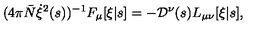

In [97]:
dataset[5]["image"]

In [98]:
instruction  = "Write the Latex Representation of the Image"

In [99]:
def convert_to_conversation(sample):
  conversation = [
      {
          "role":"user",
          "content":[
              {"type":"text" , "text":instruction},
              {"type":"image" , "image":sample["image"]}
          ]
      },
      {
          "role":"assistant",
          "content":[
              {"type":"text" , "text":sample["text"]}
          ]
      }
  ]
  return {"messages" : conversation}



In [100]:
convert_to_conversation(dataset[0])

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the Latex Representation of the Image'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

In [101]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [102]:
converted_dataset[100]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the Latex Representation of the Image'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x50>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'g _ { \\Gamma \\Omega } = { \\frac { \\delta _ { \\Gamma \\Omega } [ c ^ { 2 } + ( \\omega _ { 1 } ) ^ { 2 } ] } { [ c ^ { 2 } + ( \\omega _ { 1 } ) ^ { 2 } + ( \\omega _ { 2 } ) ^ { 2 } ] ^ { 2 } } }'}]}]}

In [103]:
FastVisionModel.for_inference(model)

PeftModel(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=False)
        

In [104]:
image = dataset[1]["image"]
messages = [
      {
          "role":"user",
          "content":[
              {"type":"text" , "text":instruction},
              {"type":"image" , "image":image}
          ]
      },
]

In [105]:
input_text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True
)

inputs = tokenizer(
    image, input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to("cuda")


In [106]:
from transformers import TextStreamer

streamer = TextStreamer(tokenizer, skip_prompt=True)

_ = model.generate(
    **inputs,
    streamer=streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)


The Latex representation of the image is:

\[ D_{\mu}^A \tilde{A}_{\mu}^B = 0 \]<|im_end|>


In [107]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer , SFTConfig

In [108]:
FastVisionModel.for_inference(model)

PeftModel(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=False)
        

In [109]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)


Unsloth: Model does not have a default image size - using 512


In [110]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936 of 8,342,231,552 (0.61% trained)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,entropy
1,1.235100,0
2,1.395900,No Log
3,1.490500,No Log
4,1.048800,No Log
5,0.969800,No Log
6,0.998600,No Log
7,0.831800,No Log
8,0.587500,No Log
9,0.397800,No Log
10,0.424500,No Log


TrainOutput(global_step=30, training_loss=0.4259425265093644, metrics={'train_runtime': 144.9326, 'train_samples_per_second': 1.656, 'train_steps_per_second': 0.207, 'total_flos': 1661933681209344.0, 'train_loss': 0.4259425265093644, 'epoch': 0.0034941618379291267})

In [111]:
FastVisionModel.for_inference(model)

PeftModel(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=False)
        

In [128]:
image = dataset[2]["image"]

In [130]:
instruction = "write the latex representation of the image."

In [131]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},  # <-- pass your image object/tensor here
            {"type": "text", "text": instruction}
        ]
    }
]

In [132]:
input_text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True
)

inputs = tokenizer(
    image, input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to("cuda")


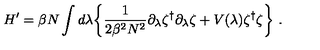

In [133]:
image

In [134]:
from transformers import TextStreamer

Text_streamer = TextStreamer(tokenizer, skip_prompt=True)

_ = model.generate(
    **inputs,
    streamer=Text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)


H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} \ .<|im_end|>
